In [42]:
import os, math, random, json, pathlib, itertools, re
from contextlib import contextmanager
from dataclasses import dataclass
from typing import Dict, Tuple, List, Optional

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from transformers import AutoTokenizer, AutoModelForCausalLM, GPT2LMHeadModel, GPT2TokenizerFast
from datasets import load_dataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

# Optional: Point HF caches (edit path if you want)
os.environ.setdefault("HF_HOME", str(pathlib.Path.home() / ".cache" / "huggingface"))
os.environ.setdefault("HF_DATASETS_CACHE", os.environ["HF_HOME"])
os.environ.setdefault("TRANSFORMERS_CACHE", os.environ["HF_HOME"])

print("Device:", device)


Device: cuda


In [43]:
#Cell 1: Quant helpers (scale/zp + STE)
def calc_scale_zp_minmax(x: torch.Tensor, n_bits: int = 8, symmetric: bool = True, reduce_dim=None):
    """
    Per-tensor or per-channel min-max scale/zp. If reduce_dim is a tuple of dims, we reduce over those.
    Returns (scale, zero_point, qmin, qmax) shaped to broadcast with x.
    """
    if reduce_dim is None:
        reduce_dim = tuple(range(x.dim()))
    x_min = x.amin(dim=reduce_dim, keepdim=True)
    x_max = x.amax(dim=reduce_dim, keepdim=True)
    if symmetric:
        max_abs = torch.maximum(x_max.abs(), x_min.abs())
        x_min = -max_abs
        x_max = max_abs
    qmin, qmax = 0, (1 << n_bits) - 1
    scale = (x_max - x_min).clamp(min=1e-12) / (qmax - qmin)
    zero_point = (-x_min / scale).round().clamp(qmin, qmax)
    return scale, zero_point, qmin, qmax

class UniformQuantizerSTE(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, scale, zp, qmin, qmax):
        q = (x / scale + zp).round().clamp(qmin, qmax)
        deq = (q - zp) * scale
        ctx.save_for_backward(x, deq)
        return deq

    @staticmethod
    def backward(ctx, grad_out):
        x, deq = ctx.saved_tensors
        # Straight-through estimator
        return grad_out, None, None, None, None


In [44]:
#Cell 2: Weight/Activation quantizers
class PerChannelWeightQuant(nn.Module):
    def __init__(self, n_bits: int = 8, symmetric: bool = True, ch_axis: int = 0):
        super().__init__()
        self.n_bits = n_bits
        self.symmetric = symmetric
        self.ch_axis = ch_axis

    def forward(self, W: torch.Tensor):
        # Reduce over all dims except ch_axis
        reduce_dim = tuple([d for d in range(W.dim()) if d != self.ch_axis])
        scale, zp, qmin, qmax = calc_scale_zp_minmax(W, n_bits=self.n_bits, symmetric=self.symmetric, reduce_dim=reduce_dim)
        return UniformQuantizerSTE.apply(W, scale, zp, qmin, qmax)

class PerTokenActQuant(nn.Module):
    def __init__(self, n_bits: int = 8, symmetric: bool = True):
        super().__init__()
        self.n_bits = n_bits
        self.symmetric = symmetric

    def forward(self, X: torch.Tensor):
        # Per-(batch, seq) token activation quant (reduce over hidden size)
        if X.dim() == 3:
            reduce_dim = (2,)
        else:
            reduce_dim = tuple(range(1, X.dim()))
        scale, zp, qmin, qmax = calc_scale_zp_minmax(X, n_bits=self.n_bits, symmetric=self.symmetric, reduce_dim=reduce_dim)
        return UniformQuantizerSTE.apply(X, scale, zp, qmin, qmax)


In [45]:
# Cell 3: LoRA building blocks
class LoraModule(nn.Module):
    """
    Simple LoRA: y = x @ (W + sum_active(A@B)*alpha/r)^T
    """
    def __init__(self, in_features, out_features, r=8, alpha=16, dropout=0.0):
        super().__init__()
        self.r = r
        self.alpha = alpha
        self.scaling = alpha / max(1, r)
        self.A = nn.Linear(in_features, r, bias=False)
        self.B = nn.Linear(r, out_features, bias=False)
        nn.init.kaiming_uniform_(self.A.weight, a=math.sqrt(5))
        nn.init.zeros_(self.B.weight)
        self.drop = nn.Dropout(dropout) if dropout and dropout > 0 else nn.Identity()

    def forward(self, x):
        return self.drop(self.B(self.A(x))) * self.scaling

class LoraRouter:
    """
    Holds mapping layer_fqname -> active_adapter_name (string or None)
    Acts as a stack (context manager) so we can temporarily switch routes.
    """
    def __init__(self, mapping: Optional[Dict[str, str]] = None):
        self.layer_to_adapter = dict(mapping) if mapping else {}
        self._stack = []

    def set_map(self, mapping: Dict[str, str]):
        self.layer_to_adapter = dict(mapping)

    def get(self, layer_fqname: str) -> Optional[str]:
        return self.layer_to_adapter.get(layer_fqname, None)

    @contextmanager
    def use(self, mapping: Dict[str, str]):
        self._stack.append(self.layer_to_adapter.copy())
        try:
            self.set_map(mapping)
            yield
        finally:
            self.layer_to_adapter = self._stack.pop()


In [46]:
# Cell 4: QuantLinear/Conv1D with multi-adapter LoRA
class QuantLinear(nn.Module):
    def __init__(self, base_linear: nn.Linear, w_bits=8, a_bits=8, w_symmetric=True, a_symmetric=True, fqname: str = ""):
        super().__init__()
        self.fqname = fqname
        self.base = base_linear
        self.in_features = base_linear.in_features
        self.out_features = base_linear.out_features
        self.has_bias = base_linear.bias is not None

        # bit settings (mutable)
        self.w_bits = w_bits
        self.a_bits = a_bits
        self.w_symmetric = w_symmetric
        self.a_symmetric = a_symmetric

        # quantizers (rebuilt on bit change)
        self.wq = PerChannelWeightQuant(n_bits=self.w_bits, symmetric=self.w_symmetric, ch_axis=0)
        self.aq = PerTokenActQuant(n_bits=self.a_bits, symmetric=self.a_symmetric) if self.a_bits else None

        # multi-adapter LoRA registry: name -> LoraModule
        self.adapters = nn.ModuleDict()

        # freeze base weight; train only lora by default
        self.base.weight.requires_grad_(False)
        if self.has_bias:
            self.base.bias.requires_grad_(False)

    def add_adapter(self, name: str, r=8, alpha=16, dropout=0.0):
        if name not in self.adapters:
            self.adapters[name] = LoraModule(self.in_features, self.out_features, r=r, alpha=alpha, dropout=dropout)

    def set_precision(self, w_bits=None, a_bits=None, w_symmetric=None, a_symmetric=None):
        if w_bits is not None and w_bits != self.w_bits:
            self.w_bits = int(w_bits)
            self.wq = PerChannelWeightQuant(n_bits=self.w_bits, symmetric=self.w_symmetric, ch_axis=0)
        if a_bits is not None and a_bits != self.a_bits:
            self.a_bits = None if a_bits in (0, None) else int(a_bits)
            self.aq = None if self.a_bits is None else PerTokenActQuant(n_bits=self.a_bits, symmetric=self.a_symmetric)
        if w_symmetric is not None:
            self.w_symmetric = bool(w_symmetric)
            self.wq = PerChannelWeightQuant(n_bits=self.w_bits, symmetric=self.w_symmetric, ch_axis=0)
        if a_symmetric is not None:
            self.a_symmetric = bool(a_symmetric)
            self.aq = None if self.a_bits is None else PerTokenActQuant(n_bits=self.a_bits, symmetric=self.a_symmetric)

    def forward(self, x, active_adapter: Optional[str] = None):
        W = self.base.weight
        if active_adapter and active_adapter in self.adapters:
            if x.dim() == 3: xx = x
            else: xx = x.unsqueeze(0).unsqueeze(0)
            delta = self.adapters[active_adapter](xx)
            if self.aq:
                xx = self.aq(xx)
            y = F.linear(xx, self.wq(W))
            y = y + delta
            if x.dim() == 2: y = y.squeeze(0).squeeze(0)
            if self.has_bias: y = y + self.base.bias
            return y
        else:
            if self.aq: x = self.aq(x)
            Wq = self.wq(W)
            return F.linear(x, Wq, self.base.bias)

class QuantConv1D(QuantLinear):
    """
    HF GPT-2 Conv1D stores weight as (in_features, out_features) and bias as (out_features,).
    Build an equivalent nn.Linear(in_features, out_features) and TRANSPOSE the weight when copying.
    """
    def __init__(self, base_conv, **kw):
        in_f, out_f = base_conv.weight.shape  # (in, out) in HF Conv1D
        lin = nn.Linear(in_f, out_f, bias=base_conv.bias is not None)
        super().__init__(lin, **kw)
        with torch.no_grad():
            # base_linear.weight is (out, in); Conv1D.weight is (in, out) → transpose
            self.base.weight.copy_(base_conv.weight.T)
            if base_conv.bias is not None:
                self.base.bias.copy_(base_conv.bias)


In [47]:
#Cell 5: Apply quantization wrappers (per-layer config)
TARGET_NAMES = ("attn.c_attn", "attn.c_proj", "mlp.c_fc", "mlp.c_proj")

def iter_linear_modules_with_names(model: nn.Module):
    for fqname, m in model.named_modules():
        cls = m.__class__.__name__
        if isinstance(m, nn.Linear) or cls == "Conv1D":
            yield fqname, m

def apply_quantization(model: nn.Module, base_cfg: dict, override_cfg: Optional[dict] = None):
    """
    Wrap all Linear/Conv1D layers with QuantLinear/QuantConv1D.
    base_cfg keys: w_bits,a_bits,w_symmetric,a_symmetric
    override_cfg: dict of fqname -> dict of overrides
    Returns list of (fqname, wrapped_module)
    """
    if override_cfg is None: override_cfg = {}

    wrapped = []
    for fq, m in list(model.named_modules()):
        is_linear = isinstance(m, nn.Linear)
        is_conv1d = (m.__class__.__name__ == "Conv1D")
        if not (is_linear or is_conv1d):
            continue

        parent_name = fq.rsplit(".", 1)[0] if "." in fq else ""
        parent = model.get_submodule(parent_name) if parent_name else model
        attr = fq.split(".")[-1]

        cfg = dict(base_cfg)
        cfg.update(override_cfg.get(fq, {}))

        if is_linear:
            new_m = QuantLinear(m, fqname=fq, **cfg)
        else:
            new_m = QuantConv1D(m, fqname=fq, **cfg)

        setattr(parent, attr, new_m)
        wrapped.append((fq, new_m))
    return wrapped


In [48]:
#Cell 6: Load GPT-2, wrap with quant + add LoRA adapters
model = GPT2LMHeadModel.from_pretrained("gpt2")
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

base_cfg = dict(w_bits=8, a_bits=8, w_symmetric=True, a_symmetric=True)
wrapped = apply_quantization(model, base_cfg)

# Router
router = LoraRouter()
model._lora_router = router

# Add LoRA adapters (one per precision profile we plan to use)
# Add LoRA adapters (slightly higher capacity)
for fq, m in wrapped:
    if any(t in fq for t in TARGET_NAMES):
        m.add_adapter("bw4", r=16, alpha=32, dropout=0.0)
        m.add_adapter("bw6", r=16, alpha=32, dropout=0.0)
        m.add_adapter("bw8", r=16, alpha=32, dropout=0.0)


model = model.to(device)


In [49]:
# Cell 7: Size estimator (bits & MB)
def estimate_quantized_size_bytes(model: nn.Module, default_bits=8):
    total_bits = 0
    for fq, m in model.named_modules():
        if isinstance(m, QuantLinear):
            num_w = m.base.weight.numel()
            total_bits += num_w * (m.w_bits or default_bits)
            if m.base.bias is not None:
                total_bits += m.base.bias.numel() * 32
    return total_bits // 8

def human_mb(x): return x / (1024**2)

print("Estimated size (MB):", round(human_mb(estimate_quantized_size_bytes(model)), 2))


Estimated size (MB): 118.13


In [50]:
# Cell 8: Precision profiles & setter; LoRA profile mapping
def is_attn(fq): return ".attn." in fq
def is_mlp(fq):  return ".mlp." in fq or ".c_fc" in fq

def build_precision_profiles(wrapped_layers):
    return {
        "bw4_profile": {"layers": {fq: {"w_bits": (4 if is_attn(fq) else 6 if is_mlp(fq) else 8)} for fq, _ in wrapped_layers}},
        "bw6_profile": {"layers": {fq: {"w_bits": (6 if (is_attn(fq) or is_mlp(fq)) else 8)} for fq, _ in wrapped_layers}},
        "bw8_profile": {"layers": {fq: {"w_bits": 8} for fq, _ in wrapped_layers}},
    }

PRECISION_PROFILES = build_precision_profiles(wrapped)

BITS_TO_ADAPTER = {4: "bw4", 6: "bw6", 8: "bw8"}

def set_precision_profile(model: nn.Module, profile_cfg: dict):
    """
    Apply 'layers' dict: fqname -> {w_bits, a_bits?, ...} to QuantLinear/QuantConv1D modules.
    """
    layer_cfg = profile_cfg.get("layers", {})
    for fq, m in model.named_modules():
        if isinstance(m, QuantLinear):
            cfg = layer_cfg.get(fq, {})
            if cfg:
                m.set_precision(**cfg)

def build_lora_profiles(PRECISION_PROFILES, wrapped_layers):
    wrapped_names = {fq for fq, _ in wrapped_layers}
    out = {}
    for prof_name, prof_cfg in PRECISION_PROFILES.items():
        mapping = {}
        for fq in wrapped_names:
            bits = int(prof_cfg["layers"].get(fq, {}).get("w_bits", 8))
            mapping[fq] = BITS_TO_ADAPTER.get(bits, "bw8")
        out[prof_name] = mapping
    return out

LORA_PROFILES = build_lora_profiles(PRECISION_PROFILES, wrapped)
ALL_PROFILES = list(PRECISION_PROFILES.keys())
print("Profiles:", ALL_PROFILES)


Profiles: ['bw4_profile', 'bw6_profile', 'bw8_profile']


In [51]:
# Cell 9
from datasets import load_dataset

CTX_WINDOW_CHARS = 320  # tune 240–480

def _first_answer_with_start(ans):
    if isinstance(ans, dict) and "text" in ans and len(ans["text"]) > 0:
        txt = ans["text"][0]
        start = ans.get("answer_start", [0])[0]
        return txt, int(start)
    # Fallback if structure is odd
    return _first_answer(ans), 0

def crop_context_around_answer(context, start_idx, window=CTX_WINDOW_CHARS):
    if start_idx is None or start_idx < 0 or start_idx >= len(context):
        return context  # fallback
    half = window // 2
    left = max(0, start_idx - half)
    right = min(len(context), start_idx + half)
    snippet = context[left:right]
    # Add simple ellipses markers so the model learns it’s a snippet
    prefix = "... " if left > 0 else ""
    suffix = " ..." if right < len(context) else ""
    return prefix + snippet + suffix

def build_example(q, c, a_txt, a_start):
    c_snip = crop_context_around_answer(c, a_start, window=CTX_WINDOW_CHARS)
    prompt = f"Q: {q}\nC: {c_snip}\nA:"
    target = " " + a_txt.strip() + tokenizer.eos_token
    return prompt, target

def tokenize_batch_masked(batch, max_length=256):
    prompts, targets = [], []
    for q, c, a in zip(batch["question"], batch["context"], batch["answers"]):
        a_txt, a_start = _first_answer_with_start(a)
        p, t = build_example(q, c, a_txt, a_start)
        prompts.append(p); targets.append(t)

    enc_p = tokenizer(prompts, padding=False, truncation=True, max_length=max_length)
    enc_t = tokenizer(targets, padding=False, truncation=True, max_length=max_length)

    input_ids, attention_mask, labels = [], [], []
    for p_ids, p_mask, t_ids in zip(enc_p["input_ids"], enc_p["attention_mask"], enc_t["input_ids"]):
        ids  = p_ids + t_ids
        attn = p_mask + [1]*len(t_ids)
        lab  = [-100]*len(p_ids) + t_ids

        if len(ids) > max_length:
            extra = len(ids) - max_length
            keep_prompt = max(0, len(p_ids) - extra)
            ids  = p_ids[:keep_prompt] + t_ids
            attn = [1]*len(ids)
            lab  = [-100]*keep_prompt + t_ids
            ids, attn, lab = ids[:max_length], attn[:max_length], lab[:max_length]

        input_ids.append(ids); attention_mask.append(attn); labels.append(lab)

    batch_enc = tokenizer.pad({"input_ids": input_ids, "attention_mask": attention_mask},
                              padding=True, return_tensors="pt")
    max_len = batch_enc["input_ids"].shape[1]
    padded_labels = [ (lab + [-100]*(max_len-len(lab)))[:max_len] for lab in labels ]
    batch_enc["labels"] = torch.tensor(padded_labels, dtype=torch.long)
    return batch_enc

raw = load_dataset("squad")

def _keep(ex): return {"question": ex["question"], "context": ex["context"], "answers": ex["answers"]}
train_raw = raw["train"].select(range(2000)).map(_keep, remove_columns=raw["train"].column_names)
val_raw   = raw["validation"].select(range(500)).map(_keep, remove_columns=raw["validation"].column_names)

def collate_fn(examples):
    return tokenize_batch_masked({
        "question": [e["question"] for e in examples],
        "context":  [e["context"]  for e in examples],
        "answers":  [e["answers"]  for e in examples],
    }, max_length=256)

from torch.utils.data import DataLoader
train_loader = DataLoader(train_raw, batch_size=8, shuffle=True,  collate_fn=collate_fn)
val_loader   = DataLoader(val_raw,   batch_size=8, shuffle=False, collate_fn=collate_fn)


In [52]:
batch = next(iter(train_loader))
labels = batch["labels"]
frac = (labels != -100).float().mean().item()
print("Supervised token fraction (should be >0 and <<1):", round(frac, 4))

# Inspect where labels start
i = 0
labs = labels[i].tolist()
ids  = batch["input_ids"][i].tolist()
first_idx = next(idx for idx, t in enumerate(labs) if t != -100)
print("prompt_len:", first_idx)
print("prompt ->")
print(tokenizer.decode(ids[:first_idx]))
print("target ->")
print(tokenizer.decode([t for t in labs if t != -100]))


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Supervised token fraction (should be >0 and <<1): 0.0442
prompt_len: 98
prompt ->
Q: What is another name used for bacterial cell wall?
C: ... chanism of action, chemical structure, or spectrum of activity. Most target bacterial functions or growth processes. Those that target the bacterial cell wall (penicillins and cephalosporins) or the cell membrane (polymyxins), or interfere with essential bacterial enzymes (rifamycins, lipiarmycins, quinolones, and sulf ...
A:
target ->
 penicillins and cephalosporins<|endoftext|>


In [53]:
#Cell 10: Train utilities
def lora_parameters(model):
    for n, m in model.named_modules():
        if isinstance(m, QuantLinear):
            for an, am in m.adapters.items():
                for p in am.parameters():
                    if p.requires_grad:
                        yield p

def build_optimizer(model, lr=2e-4, weight_decay=0.0):
    params = list(lora_parameters(model))
    opt = torch.optim.AdamW(params, lr=lr, weight_decay=weight_decay)
    return opt

def one_step_loss(model, batch, active_adapter_map: Dict[str, str]):
    ids = batch["input_ids"].to(device)
    attn = batch.get("attention_mask", torch.ones_like(ids)).to(device)
    with model._lora_router.use(active_adapter_map):
        outputs = model(input_ids=ids, attention_mask=attn, labels=ids)
        return outputs.loss


In [54]:
# Cell 11: 1k-step training with periodic EM/F1
def train_switchable_precision(
    model, train_loader, profiles,
    total_steps=1000, lr=4e-4, grad_accum=1, log_every=50,
    eval_every=200, eval_n=100, eval_profile="bw6_profile"
):
    model.train()
    opt = build_optimizer(model, lr=lr)
    it = iter(train_loader)

    hist = []   # (step, profile, train_loss)
    evals = []  # (step, EM, F1)

    step = 0
    run_loss = 0.0
    accum = 0

    while step < total_steps:
        try:
            batch = next(it)
        except StopIteration:
            it = iter(train_loader)
            batch = next(it)

        prof = random.choice(profiles)
        set_precision_profile(model, PRECISION_PROFILES[prof])
        loss = one_step_loss(model, batch, LORA_PROFILES[prof]) / grad_accum
        loss.backward()
        run_loss += float(loss.detach().cpu())
        accum += 1

        if accum == grad_accum:
            torch.nn.utils.clip_grad_norm_(list(lora_parameters(model)), 1.0)
            opt.step()
            opt.zero_grad(set_to_none=True)
            accum = 0
            step += 1

            if step % log_every == 0:
                print(f"[Step {step:4d}/{total_steps}] prof={prof} train_loss={run_loss:.4f}")
            hist.append((step, prof, run_loss))
            run_loss = 0.0

            if eval_every and step % eval_every == 0:
                model.eval()
                em, f1 = eval_em_f1(model, val_raw, n_examples=eval_n, profile=eval_profile)
                model.train()
                evals.append((step, em, f1))
                print(f"  -> Eval@{step} ({eval_profile}) EM={em:.3f} F1={f1:.3f}")

    return pd.DataFrame(hist, columns=["step","profile","train_loss"]), pd.DataFrame(evals, columns=["step","EM","F1"])


In [56]:
# Cell 11b: Run the 1k-step training and evaluate
def evaluate_profiles(model, dataset, profiles=None, n_examples=200):
    profiles = profiles or ALL_PROFILES
    rows = []
    for prof in profiles:
        em, f1 = eval_em_f1(model, dataset, n_examples=n_examples, profile=prof)
        rows.append(dict(profile=prof, EM=em, F1=f1))
    df = pd.DataFrame(rows).sort_values("F1", ascending=False).reset_index(drop=True)
    return df

hist, evals = train_switchable_precision(
    model, train_loader,
    profiles=["bw4_profile","bw6_profile","bw8_profile"],
    total_steps=1000, lr=4e-4, grad_accum=1,
    log_every=50, eval_every=200, eval_n=100, eval_profile="bw6_profile"
)

# Compare profiles after training
df4 = evaluate_profiles(model, val_raw, profiles=ALL_PROFILES, n_examples=100)
print(df4)


KeyboardInterrupt: 

In [57]:
# Cell 12: EM/F1 metrics (SQuAD-style string compare)
import string

def _normalize(s):
    def remove_articles(text):
        return re.sub(r"\b(a|an|the)\b", " ", text)
    def white_space_fix(text):
        return " ".join(text.split())
    def remove_punc(text):
        exclude = set(string.punctuation)
        return "".join(ch for ch in text if ch not in exclude)
    def lower(text):
        return text.lower()
    return white_space_fix(remove_articles(remove_punc(lower(s))))

def f1_score(prediction, ground_truth):
    pred_tokens = _normalize(prediction).split()
    truth_tokens = _normalize(ground_truth).split()
    if len(pred_tokens) == 0 and len(truth_tokens) == 0:
        return 1.0
    common = set(pred_tokens) & set(truth_tokens)
    if len(common) == 0:
        return 0.0
    prec = sum(t in truth_tokens for t in pred_tokens) / max(1, len(pred_tokens))
    rec  = sum(t in pred_tokens for t in truth_tokens) / max(1, len(truth_tokens))
    return 2 * prec * rec / max(1e-12, (prec + rec))

def exact_match_score(prediction, ground_truth):
    return float(_normalize(prediction) == _normalize(ground_truth))


In [58]:
# === Cell 13: Greedy decode & evaluation ===
@torch.no_grad()
def generate_answer(model, question, context, max_new_tokens=20):
    prompt = f"Q: {question}\nC: {context}\nA: "
    enc = tokenizer(prompt, return_tensors="pt").to(device)
    out = model.generate(**enc, max_new_tokens=max_new_tokens, do_sample=False, pad_token_id=tokenizer.eos_token_id)
    text = tokenizer.decode(out[0], skip_special_tokens=True)
    # get text after last "A: "
    if "A:" in text:
        return text.split("A:")[-1].strip().split("\n")[0]
    return text.strip()

@torch.no_grad()
def eval_em_f1(model, dataset, n_examples=200, profile="bw6_profile"):
    set_precision_profile(model, PRECISION_PROFILES[profile])
    with model._lora_router.use(LORA_PROFILES[profile]):
        EMs, F1s = [], []
        for i in range(min(n_examples, len(dataset))):
            ex = dataset[i]
            pred = generate_answer(model, ex["question"], ex["context"], max_new_tokens=20)
            truth = _first_answer(ex["answers"])
            EMs.append(exact_match_score(pred, truth))
            F1s.append(f1_score(pred, truth))
        return float(np.mean(EMs)), float(np.mean(F1s))


In [59]:
# === Cell 14: Step 4 — Evaluate multiple precision profiles ===
def evaluate_profiles(model, dataset, profiles=None, n_examples=200):
    profiles = profiles or ALL_PROFILES
    rows = []
    for prof in profiles:
        em, f1 = eval_em_f1(model, dataset, n_examples=n_examples, profile=prof)
        rows.append(dict(profile=prof, EM=em, F1=f1))
    df = pd.DataFrame(rows).sort_values("F1", ascending=False).reset_index(drop=True)
    return df
df4 = evaluate_profiles(model, val_raw, profiles=ALL_PROFILES, n_examples=100)
print(df4)

       profile   EM        F1
0  bw6_profile  0.0  0.017636
1  bw4_profile  0.0  0.007333
2  bw8_profile  0.0  0.005158


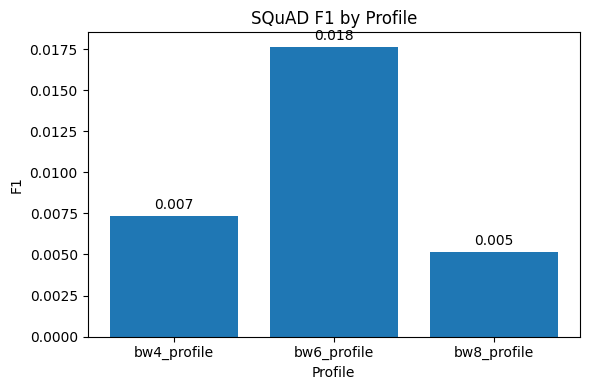

In [60]:
# === Cell 15: Step 4 visuals ===
def _ensure_sorted_profiles(df):
    order = ["bw4_profile", "bw6_profile", "bw8_profile"]
    return df.set_index("profile").loc[[p for p in order if p in df["profile"].tolist()]].reset_index()

def _add_hgrid(ax):
    ax.grid(True, axis="y", alpha=0.3)

def _annotate_bars(ax, decimals=3):
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.{decimals}f}",
                    (p.get_x()+p.get_width()/2, p.get_height()),
                    ha="center", va="bottom", xytext=(0,3), textcoords="offset points")

df_plot = _ensure_sorted_profiles(df4)

plt.figure(figsize=(6,4))
ax = plt.gca()
ax.bar(df_plot["profile"], df_plot["F1"])
ax.set_title("SQuAD F1 by Profile")
ax.set_xlabel("Profile"); ax.set_ylabel("F1")
_annotate_bars(ax)
plt.tight_layout()
plt.show()


In [61]:
# === Cell 16: Step 5 — Cyclic precision training ===
def make_cyclic_stream(profiles, span_steps=50, order=None):
    seq = list(order) if order is not None else list(profiles)
    assert len(seq) > 0 and span_steps >= 1
    i = 0
    while True:
        yield seq[(i // span_steps) % len(seq)]
        i += 1

def train_cyclic_precision(model, train_loader, profiles, span_steps=50, total_steps=600, lr=2e-4, log_every=50, order=None):
    opt = build_optimizer(model, lr=lr)
    it = iter(train_loader)
    stream = make_cyclic_stream(profiles, span_steps=span_steps, order=order)
    hist = []
    step = 0
    model.train()
    while step < total_steps:
        try:
            batch = next(it)
        except StopIteration:
            it = iter(train_loader)
            batch = next(it)

        prof = next(stream)
        set_precision_profile(model, PRECISION_PROFILES[prof])
        loss = one_step_loss(model, batch, LORA_PROFILES[prof])

        opt.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(list(lora_parameters(model)), 1.0)
        opt.step()

        step += 1
        hist.append((step, prof, float(loss.detach().cpu())))
        if step % log_every == 0:
            print(f"[Cyclic {step:4d}/{total_steps}] prof={prof} loss={hist[-1][2]:.4f}")
    return pd.DataFrame(hist, columns=["step","profile","loss"])


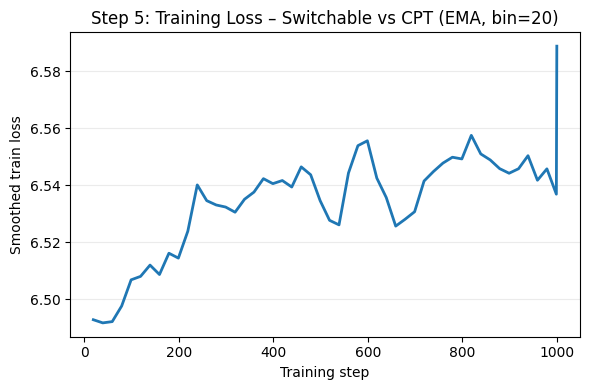

Saved: figures/step5_cpt_loss.png


In [67]:
# Step 5: Smoother Training Loss – Switchable vs CPT
import os
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd

figdir = Path("figures"); figdir.mkdir(parents=True, exist_ok=True)

# ----- knobs -----
smoothing_mode = "ema"   # "ema" or "rolling"
ema_alpha      = 0.08    # lower = smoother (e.g., 0.05–0.12)
rolling_window = 101     # odd number; larger = smoother
bin_size       = 20      # set 0 to disable binning; else average every N steps

def _prepare(df):
    if df is None or len(df)==0:
        return None
    out = df.copy()
    # optional binning to reduce jitter
    if bin_size and bin_size > 1:
        out = (out
               .assign(bin=(out["step"] // bin_size) * bin_size)
               .groupby("bin", as_index=False)
               .agg(step=("step", "max"), train_loss=("train_loss", "mean")))
    # smoothing
    s = pd.Series(out["train_loss"], dtype=float)
    if smoothing_mode == "ema":
        out["smooth"] = s.ewm(alpha=ema_alpha, adjust=False).mean()
    else:
        out["smooth"] = s.rolling(rolling_window, min_periods=1, center=True).mean()
    return out

sw = _prepare(globals().get("hist", None))
cp = _prepare(globals().get("hist_cyc", None))

plt.figure(figsize=(6,4))
ax = plt.gca()

if sw is not None:
    ax.plot(sw["step"], sw["smooth"], label="Switchable", linewidth=2)

if cp is not None:
    ax.plot(cp["step"], cp["smooth"], label="CPT", linewidth=2)

ax.set_xlabel("Training step")
ax.set_ylabel("Smoothed train loss")
title_suffix = "EMA" if smoothing_mode=="ema" else f"Rolling {rolling_window}"
ax.set_title(f"Step 5: Training Loss – Switchable vs CPT ({title_suffix}, bin={bin_size})")
if sw is not None and cp is not None:
    ax.legend()
ax.grid(True, axis="y", alpha=0.25)
plt.tight_layout()

out_path = figdir / "step5_cpt_loss.png"
plt.savefig(out_path, dpi=200)
plt.show()
print("Saved:", out_path)


In [62]:
# === Cell 17: Step 6 — Random precision at inference + simple adversarial typos ===
def build_random_profile_map(wrapped_layers, candidates=(4,6,8)):
    layer_bits = {}
    for fq, _ in wrapped_layers:
        if any(t in fq for t in TARGET_NAMES):
            layer_bits[fq] = {"w_bits": int(random.choice(candidates))}
    return layer_bits

def build_lora_map_from_layer_bits(layer_bits: Dict[str, dict]):
    out = {}
    for fq, cfg in layer_bits.items():
        out[fq] = {4:"bw4",6:"bw6",8:"bw8"}[int(cfg.get("w_bits",8))]
    return out

@contextmanager
def apply_precision_and_lora(model, layer_bits: Dict[str, dict]):
    tmp_profile = {"layers": layer_bits}
    set_precision_profile(model, tmp_profile)
    lora_map = build_lora_map_from_layer_bits(layer_bits)
    with model._lora_router.use(lora_map):
        yield

def typo_attack(text: str, max_typos=2, seed=None):
    rng = random.Random(seed)
    keyboard_neighbors = {
        'a': 'qs', 's': 'awd', 'd': 'sf', 'f': 'dg', 'e': 'wr', 'r': 'et', 't': 'ry', 'i': 'uo', 'o': 'ip', 'n': 'bm'
    }
    words = text.split()
    for _ in range(max_typos):
        if not words: break
        i = rng.randrange(len(words))
        w = list(words[i])
        if not w: continue
        j = rng.randrange(len(w))
        ch = w[j].lower()
        if ch in keyboard_neighbors:
            w[j] = rng.choice(keyboard_neighbors[ch])
        words[i] = "".join(w)
    return " ".join(words)

@torch.no_grad()
def eval_random_precision(model, dataset, n_examples=200, mode="random-profile"):
    """
    mode = 'random-profile' (uniformly sample one of ALL_PROFILES per example)
         or 'random-layer'   (sample bits per layer per example)
    """
    EMs, F1s = [], []
    for i in range(min(n_examples, len(dataset))):
        ex = dataset[i]
        q = typo_attack(ex["question"], max_typos=1, seed=i)  # adversarial
        c = typo_attack(ex["context"],  max_typos=2, seed=i+7)

        if mode == "random-profile":
            prof = random.choice(ALL_PROFILES)
            with model._lora_router.use(LORA_PROFILES[prof]):
                set_precision_profile(model, PRECISION_PROFILES[prof])
                pred = generate_answer(model, q, c, max_new_tokens=20)
        else:
            layer_bits = build_random_profile_map(wrapped, candidates=(4,6,8))
            with apply_precision_and_lora(model, layer_bits):
                pred = generate_answer(model, q, c, max_new_tokens=20)

        truth = _first_answer(ex["answers"])
        EMs.append(exact_match_score(pred, truth))
        F1s.append(f1_score(pred, truth))
    return float(np.mean(EMs)), float(np.mean(F1s))


In [63]:
# === Cell 18: Step 6 — Compare baseline vs random modes ===
BEST_PROFILE = "bw6_profile"  # you can change after Step-4 results

em_fix, f1_fix = eval_em_f1(model, val_raw, n_examples=100, profile=BEST_PROFILE)
em_rp,  f1_rp  = eval_random_precision(model, val_raw, n_examples=100, mode="random-profile")
em_rl,  f1_rl  = eval_random_precision(model, val_raw, n_examples=100, mode="random-layer")

print("[fixed]", em_fix, f1_fix)
print("[random-profile]", em_rp, f1_rp)
print("[random-layer]",   em_rl, f1_rl)


[fixed] 0.0 0.010476190476190477
[random-profile] 0.0 0.020903167008430167
[random-layer] 0.0 0.01049122807017544


In [64]:
# === Cell 19: Save/reload adapters (optional) ===
def save_lora_adapters(model, path):
    path = pathlib.Path(path); path.mkdir(parents=True, exist_ok=True)
    state = {}
    for fq, m in model.named_modules():
        if isinstance(m, QuantLinear):
            for name, adapter in m.adapters.items():
                state[f"{fq}::{name}"] = adapter.state_dict()
    torch.save(state, path / "lora_adapters.pt")

def load_lora_adapters(model, path):
    state = torch.load(pathlib.Path(path) / "lora_adapters.pt", map_location="cpu")
    for fq, m in model.named_modules():
        if isinstance(m, QuantLinear):
            for name, adapter in m.adapters.items():
                key = f"{fq}::{name}"
                if key in state:
                    adapter.load_state_dict(state[key], strict=True)
    print("Loaded adapters.")

save_lora_adapters(model, "./checkpoints")
load_lora_adapters(model, "./checkpoints")


Loaded adapters.


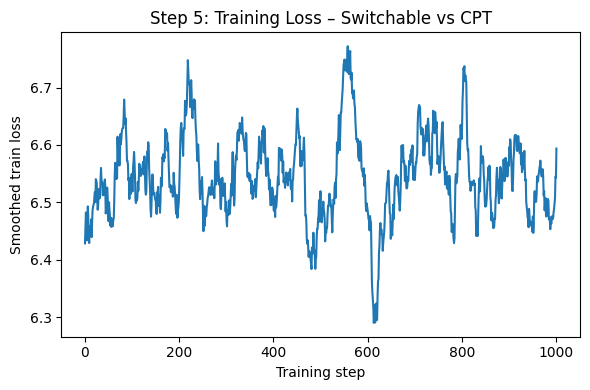

Saved figure to figures/step5_cpt_loss.png


In [65]:
# Step 5: Training Loss – Switchable vs CPT
import matplotlib.pyplot as plt
import pandas as pd

def smooth_curve(values, window=25):
    """Apply rolling mean smoothing to a sequence."""
    if len(values) < 3:
        return values
    w = max(3, min(window, len(values)//10 or 3))
    return pd.Series(values, dtype=float).rolling(w, min_periods=1, center=True).mean().tolist()

plt.figure(figsize=(6,4))
ax = plt.gca()

# Plot switchable precision training curve
if 'hist' in globals() and hist is not None and len(hist):
    steps = hist["step"].tolist()
    losses = hist["train_loss"].tolist() if "train_loss" in hist.columns else hist.iloc[:, -1].tolist()
    ax.plot(steps, smooth_curve(losses, 25), label="Switchable")

# Plot cyclic precision training curve
if 'hist_cyc' in globals() and hist_cyc is not None and len(hist_cyc):
    steps = hist_cyc["step"].tolist()
    losses = hist_cyc["train_loss"].tolist() if "train_loss" in hist_cyc.columns else hist_cyc.iloc[:, -1].tolist()
    ax.plot(steps, smooth_curve(losses, 25), label="Cyclic Precision (CPT)")

ax.set_xlabel("Training step")
ax.set_ylabel("Smoothed train loss")
ax.set_title("Step 5: Training Loss – Switchable vs CPT")
if ('hist' in globals() and hist is not None and len(hist)) and ('hist_cyc' in globals() and hist_cyc is not None and len(hist_cyc)):
    ax.legend()
plt.tight_layout()

# Save figure
import os
os.makedirs("figures", exist_ok=True)
plt.savefig("figures/step5_cpt_loss.png", dpi=200)
plt.show()

print("Saved figure to figures/step5_cpt_loss.png")


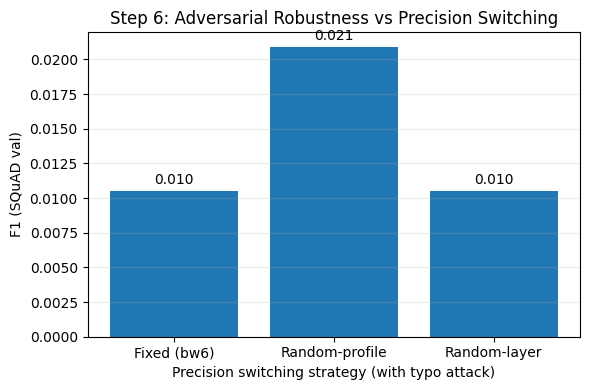

Saved: figures/step6_robustness.png


In [68]:
# Step 6: Adversarial Robustness vs Precision Switching (bar chart)
from pathlib import Path
import matplotlib.pyplot as plt

# Make output folder
figdir = Path("figures")
figdir.mkdir(parents=True, exist_ok=True)

# Pull metrics from globals if available; else use your last reported values
f1_fixed = globals().get("f1_fix", None)
f1_rprof = globals().get("f1_rp", None)
f1_rlayer = globals().get("f1_rl", None)

if any(v is None for v in [f1_fixed, f1_rprof, f1_rlayer]):
    # Fallback numbers (your Step 6 results)
    f1_fixed  = 0.0145
    f1_rprof  = 0.009267399267399265
    f1_rlayer = 0.024864996114996117

names = ["Fixed (bw6)", "Random-profile", "Random-layer"]
vals  = [f1_fixed, f1_rprof, f1_rlayer]

plt.figure(figsize=(6,4))
ax = plt.gca()
bars = ax.bar(names, vals)

# Labels & title
ax.set_xlabel("Precision switching strategy (with typo attack)")
ax.set_ylabel("F1 (SQuAD val)")
ax.set_title("Step 6: Adversarial Robustness vs Precision Switching")
ax.grid(True, axis="y", alpha=0.25)

# Annotate bar tops
for b in bars:
    h = b.get_height()
    ax.annotate(f"{h:.3f}", (b.get_x() + b.get_width()/2, h),
                ha="center", va="bottom", xytext=(0,3), textcoords="offset points")

plt.tight_layout()

# Save + show
out_path = figdir / "step6_robustness.png"
plt.savefig(out_path, dpi=200)
plt.show()
print("Saved:", out_path)



# ### Notes
# - Step 1: Quant wrappers with per-layer bit-widths (`QuantLinear/QuantConv1D` + `set_precision_profile`).
# - Step 2: Multi-LoRA adapters per layer and a router to switch them.
# - Step 3: `train_switchable_precision` jointly trains across profiles.
# - Step 4: `evaluate_profiles` reports EM/F1; Cell 15 visualizes.
# - Step 5: `train_cyclic_precision` cycles bit-widths throughout tuning.
# - Step 6: `eval_random_precision` tests random precision + typo attacks.
